In [111]:
!pip install numpy

You should consider upgrading via the 'C:\Users\jamilur\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [112]:
!pip install sklearn tensorflow 

You should consider upgrading via the 'C:\Users\jamilur\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [113]:
!pip install pandas

You should consider upgrading via the 'C:\Users\jamilur\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Load datasets

In [114]:
import pandas as pd

dataset = pd.read_csv('translation-dataset/generated_reviews_crowd.csv')
dataset.head(5)

,en_text,th_text
0,Doesn't snap together well.,เข้ากันไม่ค่อยดี
1,Charged it after every use as directed for abo...,เรียกเก็บเงินหลังจากใช้งานทุกครั้งตามที่กำกับไ...
2,"My son wanted this movie so badly, that he sai...",ลูกชายของฉันต้องการภาพยนตร์เรื่องนี้เพื่อไม่ดี...
3,But his writing has degenerated in later books.,แต่หนังสือเล่มที่ผ่านมาของเขามันดูด้อยคุณภาพลง
4,"It was supposed to be a good bag, well you get...",มันควรที่จะเป็นกระเป๋าที่ดี เอ้อ เธอได้ในสิ่งท...


In [115]:
print(dataset.shape)

dataset.head(3)

(24587, 2)


,en_text,th_text
0,Doesn't snap together well.,เข้ากันไม่ค่อยดี
1,Charged it after every use as directed for abo...,เรียกเก็บเงินหลังจากใช้งานทุกครั้งตามที่กำกับไ...
2,"My son wanted this movie so badly, that he sai...",ลูกชายของฉันต้องการภาพยนตร์เรื่องนี้เพื่อไม่ดี...


In [116]:
# Data cleaning
from string import punctuation
import random
import string
import re


def clean_string(string):
    # Replace no-break space with space
    string = string.replace("\u202f"," ")
    # Converts all uppercase characters into lowercase characters
    string = string.lower()

    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")

    # Eliminate duplicate whitespaces using wildcards   
    string = re.sub("\s+"," ", string)
    # Remove spaces at the beginning and at the end of the string
    string = string.strip()
           
    return string
dataset["en_text"] = dataset["en_text"].astype(str)
dataset["th_text"]  = dataset["th_text"].astype(str)

dataset["en_text"] = dataset["en_text"].apply(lambda x: clean_string(x))
dataset["th_text"]  = dataset["th_text"].apply(lambda x: clean_string(x))


In [117]:
raw_data_en = dataset["en_text"].values
raw_data_th = dataset["th_text"].values

# Add start and end
raw_data_en_in_out = ["[start] " + st + " [end]" for st in raw_data_en]

for _ in range(5):
    print(random.choice(raw_data_en_in_out))

print("\n---------------------------------------------------------------------")
# Each line contains an English sentence and its corresponding French sentence. 
# The English sentence is the source sequence and the French one is the target sequence.
my_data = []
for i in range(len(raw_data_th)):
    th = raw_data_th[i]
    en = raw_data_en_in_out[i]
    my_data.append((th, en))
    
my_data[:5]

[start] will stop using since can t afford doing every time its full [end]
[start] i have found that this book is rather weak when it comes to explaining why the authors recommend certain tips [end]
[start] the product they sent me didn t even look like what you see here and certainly wasn t the item pictured on amazon [end]
[start] most obvious was that you need an awful lot of knowledge or understanding about how people think on a daily basis at least if you re going for plausible fiction [end]
[start] have had these now about months [end]

---------------------------------------------------------------------


[('เข้ากันไม่ค่อยดี', '[start] doesn t snap together well [end]'),
 ('เรียกเก็บเงินหลังจากใช้งานทุกครั้งตามที่กำกับไว้เป็นเวลาประมาณ เดือนเริ่มมีปัญหาในการเก็บประจุ',
  '[start] charged it after every use as directed for about months started having difficulty holding a charge on it [end]'),
 ('ลูกชายของฉันต้องการภาพยนตร์เรื่องนี้เพื่อไม่ดี ที่เขากล่าวว่ามันอย่างน้อย ครั้ง',
  '[start] my son wanted this movie so badly that he said it at least times [end]'),
 ('แต่หนังสือเล่มที่ผ่านมาของเขามันดูด้อยคุณภาพลง',
  '[start] but his writing has degenerated in later books [end]'),
 ('มันควรที่จะเป็นกระเป๋าที่ดี เอ้อ เธอได้ในสิ่งที่เธอจ่ายไป',
  '[start] it was supposed to be a good bag well you get what you pay for [end]')]

In [118]:
# Shuffle dataset

random.shuffle(my_data)

# Train_set = 80%, Test_set = 10%, Val_set = 10%
num_val_samples = int(0.1 * len(my_data))
num_train_samples = len(my_data) - 2 * num_val_samples

train_pairs = my_data[:num_train_samples]
val_pairs   = my_data[num_train_samples : num_train_samples + num_val_samples]
test_pairs  = my_data[num_train_samples + num_val_samples :]

print("Total pairs in my dtat : ",len(my_data))
print("Training pairs         : ",len(train_pairs))
print("Validation pairs       : ",len(val_pairs))
print("Test pairs             : ",len(test_pairs))

Total pairs in my dtat :  24587
Training pairs         :  19671
Validation pairs       :  2458
Test pairs             :  2458


In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [120]:


# Vectorizing the text data
vocab_size      = 15000
sequence_length = 25
batch_size      = 64

en_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", 
    output_sequence_length = sequence_length + 1,)

th_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,)

train_th_texts = [pair[0] for pair in train_pairs]
train_en_texts = [pair[1] for pair in train_pairs]

en_vectorization.adapt(train_en_texts)
th_vectorization.adapt(train_th_texts)
 
print("Done ...")



Done ...


In [121]:
def format_dataset(en, th):
    th = th_vectorization(th)
    en = en_vectorization(en)
    return ({"encoder_inputs": th, "decoder_inputs": en[:, :-1],}, en[:, 1:])

def make_dataset(pairs):
    th_texts, en_texts = zip(*pairs)

    th_texts = list(th_texts)
    en_texts = list(en_texts)

    dataset = tf.data.Dataset.from_tensor_slices((en_texts, th_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(1024).prefetch(32).cache()


train_dataset = make_dataset(train_pairs)
val_dataset   = make_dataset(val_pairs)

for inputs, targets in train_dataset.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 25)
inputs["decoder_inputs"].shape: (64, 25)
targets.shape: (64, 25)


In [122]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
         #-----------------------------------------------------------------------
        self.sequence_length = sequence_length
        self.vocab_size      = vocab_size
        self.embed_dim       = embed_dim

        #-----------------------------------------------------------------------
        # L3
        self.input_embeddings = layers.Embedding(
                                     input_dim=vocab_size, output_dim=embed_dim)
        
        #-----------------------------------------------------------------------
        # L4
        self.positional_encoding = layers.Embedding(
                                input_dim=sequence_length, output_dim=embed_dim)
       
    #---------------------------------------------------------------------------
    def call(self, inputs):
        length    = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        # L3
        embedded_inputs    = self.input_embeddings(inputs)
        # L4
        embedded_positions = self.positional_encoding(positions)
        # L5
        return embedded_inputs + embedded_positions

    #---------------------------------------------------------------------------
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
        
#*******************************************************************************
print("Done ...")

Done ...


In [123]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        #-----------------------------------------------------------------------
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # L6
        self.attention = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        # L8
        self.feed_forward = keras.Sequential([
                                  layers.Dense(dense_dim, activation="relu"), 
                                   layers.Dense(embed_dim),])
        
        # L7
        self.normalization_1  = layers.LayerNormalization()
        # L9
        self.normalization_2  = layers.LayerNormalization()
        self.supports_masking = True

    #---------------------------------------------------------------------------
    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

        #-----------------------------------------------------------------------
        # L6
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        
        #-----------------------------------------------------------------------
        # L7
        addnorm_output_1 = self.normalization_1(inputs + attention_output)
        # L8
        feedforward_output = self.feed_forward(addnorm_output_1)
        # L9
        addnorm_output_2 = self.normalization_2(addnorm_output_1 + feedforward_output)
        # L10
        return addnorm_output_2

#*******************************************************************************
print("Done ...")

Done ...


In [124]:


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        #-----------------------------------------------------------------------
        self.embed_dim  = embed_dim
        self.latent_dim = latent_dim
        self.num_heads  = num_heads

        #-----------------------------------------------------------------------
        # L11
        self.attention_1 = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        # L13
        self.attention_2 = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        #-----------------------------------------------------------------------
        # L15
        self.feed_forward = keras.Sequential([
          layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        
        # L12
        self.normalization_1  = layers.LayerNormalization()
        # L14
        self.normalization_2  = layers.LayerNormalization()
        # L16
        self.normalization_3  = layers.LayerNormalization()
        self.supports_masking = True

    #---------------------------------------------------------------------------
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)

        #-----------------------------------------------------------------------
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        #-----------------------------------------------------------------------
        # L11
        attention_output_1 = self.attention_1(
             query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        # L12
        addnorm_output_1 = self.normalization_1(inputs + attention_output_1)

        #-----------------------------------------------------------------------
        # L13
        attention_output_2 = self.attention_2(
            query=addnorm_output_1, value=encoder_outputs, key=encoder_outputs,
            attention_mask=padding_mask,)
        # L14
        addnorm_output_2 = self.normalization_2(addnorm_output_1 + attention_output_2)

        #-----------------------------------------------------------------------
        # L15
        feedforward_output = self.feed_forward(addnorm_output_2)
        # L16
        addnorm_output_3 = self.normalization_3(addnorm_output_2 + feedforward_output)

        return addnorm_output_3

    #---------------------------------------------------------------------------
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
        
#*******************************************************************************
print("Done ...")



Done ...


In [125]:
!pip install pydot graphviz

You should consider upgrading via the 'C:\Users\jamilur\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [126]:
embed_dim  = 128
latent_dim = 1024
num_heads  = 10

#-------------------------------------------------------------------------------
# L1
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
# L3, L4, L5
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

#-------------------------------------------------------------------------------
# From L6 to L10
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
# Encoder
encoder         = keras.Model(encoder_inputs, encoder_outputs)

#-------------------------------------------------------------------------------
# L2
decoder_inputs     = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
# L10
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
# L3, L4, L5
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# From L11 to L16
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

#-------------------------------------------------------------------------------
# Output Probabilities
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

#-------------------------------------------------------------------------------
# Decoder
decoder         = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

#-------------------------------------------------------------------------------
# My Transformer
my_transformer = keras.Model(
                          [encoder_inputs, decoder_inputs], 
                          decoder_outputs, name="my_transformer")

# The model’s summary() method displays all the model’s layers
print(my_transformer.summary())

# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(my_transformer, show_shapes=True)

Model: "my_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_12 (Posit  (None, None, 128)   1923200     ['encoder_inputs[0][0]']         
 ionalEmbedding)                                                                                  
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_6 (Transfo  (None, None, 128)   923136      ['positional_embeddi

In [127]:
!pip install -U tensorflow-addons

You should consider upgrading via the 'C:\Users\jamilur\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [128]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(
        learning_rate = 0.001, weight_decay=0.0001)

# Compiling the model
my_transformer.compile(loss="sparse_categorical_crossentropy", 
                       optimizer = optimizer, metrics = ["accuracy"])

# Training the model 
epochs = 20 # You have to train it longer to converge
history = my_transformer.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20
308/308 [==============================] - 228s 732ms/step - loss: 3.6995 - accuracy: 0.1497 - val_loss: 3.2109 - val_accuracy: 0.1941
Epoch 2/20
308/308 [==============================] - 222s 720ms/step - loss: 3.1532 - accuracy: 0.2013 - val_loss: 3.0709 - val_accuracy: 0.2074
Epoch 3/20
308/308 [==============================] - 224s 729ms/step - loss: 2.9937 - accuracy: 0.2171 - val_loss: 3.0117 - val_accuracy: 0.2128
Epoch 4/20
308/308 [==============================] - 222s 722ms/step - loss: 2.8742 - accuracy: 0.2309 - val_loss: 2.9798 - val_accuracy: 0.2136
Epoch 5/20
308/308 [==============================] - 222s 720ms/step - loss: 2.7741 - accuracy: 0.2435 - val_loss: 2.9597 - val_accuracy: 0.2203
Epoch 6/20
308/308 [==============================] - 223s 724ms/step - loss: 2.6857 - accuracy: 0.2554 - val_loss: 2.9750 - val_accuracy: 0.2218
Epoch 7/20
308/308 [==============================] - 255s 829ms/step - loss: 2.6067 - accuracy: 0.2672 - val_loss: 2.9649 -

In [130]:
!pip install matplotlib

You should consider upgrading via the 'C:\Users\jamilur\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



     ---------------------------------------- 7.2/7.2 MB 472.3 kB/s eta 0:00:00
     ------------------------------------ 944.1/944.1 KB 686.7 kB/s eta 0:00:00
     -------------------------------------- 55.3/55.3 KB 726.2 kB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 337.2 kB/s eta 0:00:00


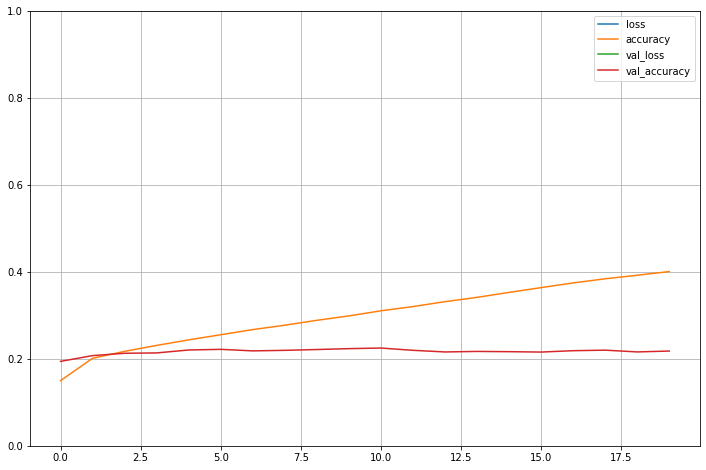

39/39 [==============================] - 13s 339ms/step - loss: 3.2377 - accuracy: 0.2183
Loss     :  3.2377452850341797
accuracy :  0.21825067698955536


In [131]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
test_dataset   = make_dataset(test_pairs)
model_evaluate = my_transformer.evaluate(test_dataset)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

In [132]:
#-------------------------------------------------------------------------------
en_vocab = en_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))
max_decoded_sentence_length = 20

#-------------------------------------------------------------------------------
def decode_sequence(input_sentence):
    tokenized_input_sentence = th_vectorization([input_sentence])

    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = en_vectorization([decoded_sentence])[:, :-1]
        predictions = my_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = en_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

#-------------------------------------------------------------------------------
test_th_texts = [pair[0] for pair in test_pairs]
exp = 0
for i in range(30):
    input_sentence = random.choice(test_th_texts)
    translated = decode_sequence(input_sentence)
    print("Example : ",exp)
    print("TH: ",test_th_texts[i])

    translated = translated.replace("[start]", "")
    translated = translated.replace("[UNK]", "")
    translated = translated.replace("end", "")
    print("EN: ",translated)
    exp = exp + 1
    print("-------------------------------------------------------------------")

Example :  0
TH:  นี่เป็นกล้องดิจิตอลตัวแรกของฉันที่ไม่ได้มาพร้อมกับคู่มือการใช้งาน
EN:   i m not sure if it s worth buying   buying  this  my  up with led
-------------------------------------------------------------------
Example :  1
TH:  รูปภาพก็สวยซะด้วย
EN:   i m not sure if it s worth buying it    for buying  and it fixed more
-------------------------------------------------------------------
Example :  2
TH:  ฉันตื่นเต้นมากๆ เมื่อหนังสือมาอยู่ในกล่องจดหมายของฉัน เพราะได้ยินมาว่ามันน่าสนใจ แต่พออ่านแล้วกลับน่าเบื่อ
EN:   i m not sure if it s worth buying    buying  buying another   from amazon
-------------------------------------------------------------------
Example :  3
TH:  ผมผิดหวังเล็กน้อยกับหนังสือเล่มนี้เป็นหลักฐานที่น่าสนใจและเธอสร้างตัวละครที่น่าสนใจมากบาง
EN:   i m not sure if it s worth buying      buying the    
-------------------------------------------------------------------
Example :  4
TH:  เกมนี้สนุกดี กราฟฟิคสวยและก็มีเนื้อหาใหม่ๆอยู่เสมอ
EN:   i m not sure